In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.fftpack
import scipy.signal

import pyrex

np.random.seed(123)

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Quick Links

[Working with Signal Objects](#signals)

[Antenna Class and Subclasses](#antennas)

[AntennaSystem and Detector Classes](#detector)

[Ice and Earth Models](#models)

[Ray Tracing](#ray_tracing)

[Particle Generation](#particles)

[Full Simulation](#kernel)

[Data File I/O](#data_io)

<a id="signals"></a>
# Working with Signal Objects

The base ``Signal`` class is simply an array of times and an array of signal values, and is instantiated with these two arrays. The ``times`` array is assumed to be in units of seconds, but there are no general units for the ``values`` array. It is worth noting that the Signal object stores shallow copies of the passed arrays, so changing the original arrays will not affect the ``Signal`` object.

In [2]:
time_array = np.linspace(0, 10)
value_array = np.sin(time_array)
my_signal = pyrex.Signal(times=time_array, values=value_array)

Plotting the ``Signal`` object is as simple as plotting the times vs the values:

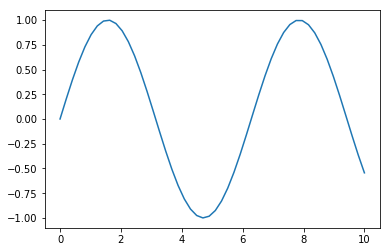

In [3]:
plt.plot(my_signal.times, my_signal.values)
plt.show()

While there are no specified units for a ``Signal.values``, there is the option to specify the ``value_type`` of the ``values``. This is done using the ``Signal.Type`` enum. By default, a ``Signal`` object has ``value_type=Type.unknown``. However, if the signal represents a voltage, electric field, or electric power; ``value_type`` can be set to ``Signal.Type.voltage``, ``Signal.Type.field``, or ``Signal.Type.power`` respectively:

In [4]:
my_voltage_signal = pyrex.Signal(times=time_array, values=value_array,
                                 value_type=pyrex.Signal.Type.voltage)

``Signal`` objects can be added as long as they have the same time array and ``value_type``. ``Signal`` objects also support the python ``sum`` function:

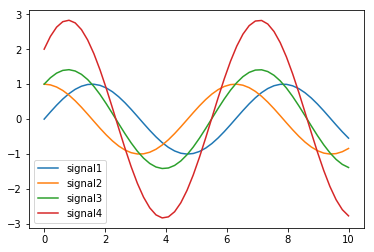

In [5]:
time_array = np.linspace(0, 10)
values1 = np.sin(time_array)
values2 = np.cos(time_array)
signal1 = pyrex.Signal(time_array, values1)
plt.plot(signal1.times, signal1.values, label="signal1")
signal2 = pyrex.Signal(time_array, values2)
plt.plot(signal2.times, signal2.values, label="signal2")
signal3 = signal1 + signal2
plt.plot(signal3.times, signal3.values, label="signal3")
all_signals = [signal1, signal2, signal3]
signal4 = sum(all_signals)
plt.plot(signal4.times, signal4.values, label="signal4")
plt.legend()
plt.show()

The ``Signal`` class provides many convenience attributes for dealing with signals:

In [6]:
print(my_signal.dt == my_signal.times[1] - my_signal.times[0])
print(my_signal.spectrum == scipy.fftpack.fft(my_signal.values))
print(my_signal.frequencies == scipy.fftpack.fftfreq(n=len(my_signal.values), d=my_signal.dt))
print(my_signal.envelope == np.abs(scipy.signal.hilbert(my_signal.values)))

True
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True]


The ``Signal`` class also provides functions for manipulating the signal. The ``resample`` function will resample the times and values arrays to the given number of points (with the same endpoints):

True
True
True


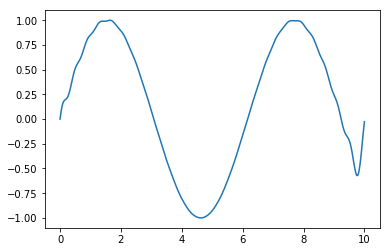

In [7]:
my_signal.resample(1001)
print(len(my_signal.times) == len(my_signal.values) == 1001)
print(my_signal.times[0] == 0)
print(my_signal.times[-1] == 10)
plt.plot(my_signal.times, my_signal.values)
plt.show()

The ``with_times`` function will interpolate/extrapolate the signal's values onto a new times array:

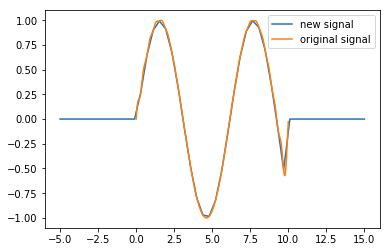

In [8]:
new_times = np.linspace(-5, 15)
new_signal = my_signal.with_times(new_times)
plt.plot(new_signal.times, new_signal.values, label="new signal")
plt.plot(my_signal.times, my_signal.values, label="original signal")
plt.legend()
plt.show()

The ``filter_frequencies`` function will apply a frequency-domain filter to the values array based on the passed frequency response function. In cases where the filter is designed for only positive freqeuncies (as below) the filtered frequency may have strange behavior including having an imaginary part. To resolve that issue, pass ``force_real=True`` to the ``filter_frequencies`` function which will extrapolate the given filter to negative frequencies and ensure a real-valued filtered signal.

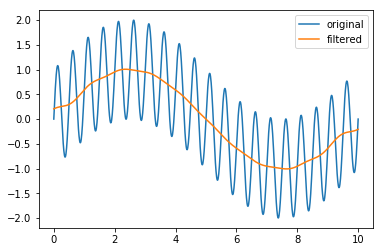

In [9]:
def lowpass_filter(frequency):
    if frequency < 1:
        return 1
    else:
        return 0
    
time_array = np.linspace(0, 10, 1001)
value_array = np.sin(0.1*2*np.pi*time_array) + np.sin(2*2*np.pi*time_array)
my_signal = pyrex.Signal(times=time_array, values=value_array)

plt.plot(my_signal.times, my_signal.values, label="original")
my_signal.filter_frequencies(lowpass_filter, force_real=True)
plt.plot(my_signal.times, my_signal.values, label="filtered")
plt.legend()
plt.show()

A number of classes which inherit from the Signal class are included in PyREx: ``EmptySignal``, ``FunctionSignal``, ``AskaryanSignal``, and ``ThermalNoise``. ``EmptySignal`` is simply a signal whose values are all zero:

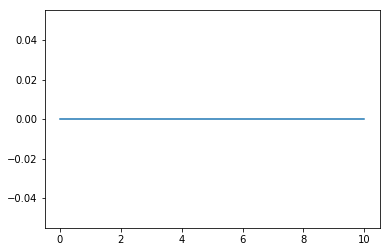

In [10]:
time_array = np.linspace(0,10)
empty = pyrex.EmptySignal(times=time_array)
plt.plot(empty.times, empty.values)
plt.show()

``FunctionSignal`` takes a function of time and creates a signal based on that function:

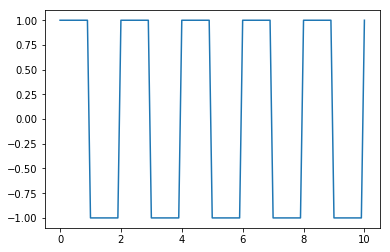

In [11]:
time_array = np.linspace(0, 10, num=101)
def square_wave(time):
    if int(time)%2==0:
        return 1
    else:
        return -1
square_signal = pyrex.FunctionSignal(times=time_array, function=square_wave)
plt.plot(square_signal.times, square_signal.values)
plt.show()

Additionally, ``FunctionSignal`` leverages its knowledge of the function to more accurately interpolate and extrapolate values for the ``with_times`` function:

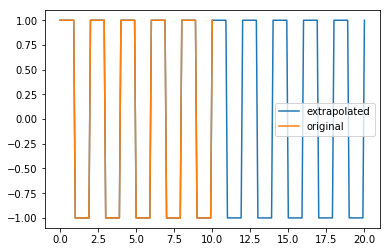

In [12]:
new_times = np.linspace(0, 20, num=201)
long_square_signal = square_signal.with_times(new_times)
plt.plot(long_square_signal.times, long_square_signal.values, label="extrapolated")
plt.plot(square_signal.times, square_signal.values, label="original")
plt.legend()
plt.show()

``AskaryanSignal`` produces an Askaryan pulse (in V/m) on a time array resulting from a given neutrino observed at a given angle from the shower axis and at a given distance from the shower vertex. For more about using the ``Particle`` class, jump to [Particle Generation](#particles).

Type.field


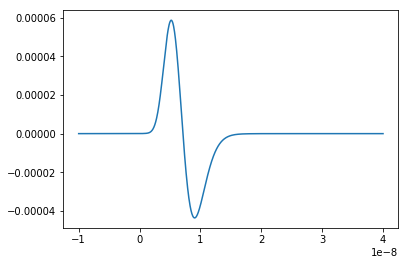

In [13]:
time_array = np.linspace(-10e-9, 40e-9, 1001)
neutrino_energy = 1e8 # GeV
neutrino = pyrex.Particle("nu_e", vertex=(0, 0, -1000), direction=(0, 0, -1),
                          energy=neutrino_energy)
neutrino.interaction.em_frac = 1
neutrino.interaction.had_frac = 0
observation_angle = 45 * np.pi/180 # radians
observation_distance = 2000 # meters
askaryan = pyrex.AskaryanSignal(times=time_array, particle=neutrino,
                                viewing_angle=observation_angle,
                                viewing_distance=observation_distance)
print(askaryan.value_type)
plt.plot(askaryan.times, askaryan.values)
plt.show()

``ThermalNoise`` produces Rayleigh noise (in V) at a given temperature and resistance which has been passed through a bandpass filter of the given frequency range:

Type.voltage


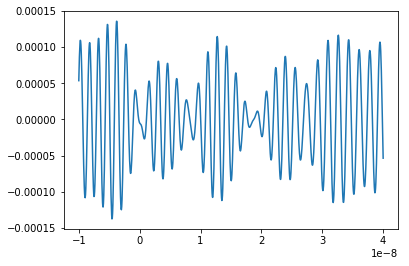

In [14]:
time_array = np.linspace(-10e-9, 40e-9, 1001)
noise_temp = 300 # K
system_resistance = 1000 # ohm
frequency_range = (550e6, 750e6) # Hz
noise = pyrex.ThermalNoise(times=time_array, temperature=noise_temp,
                           resistance=system_resistance,
                           f_band=frequency_range)
print(noise.value_type)
plt.plot(noise.times, noise.values)
plt.show()

Note that since ``ThermalNoise`` inherits from ``FunctionSignal``, it can be extrapolated nicely to new times. It may be highly periodic outside of its original time range however, unless a large number of frequencies is requested on initialization.

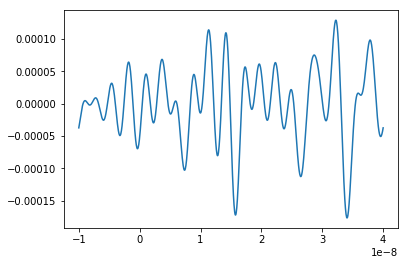

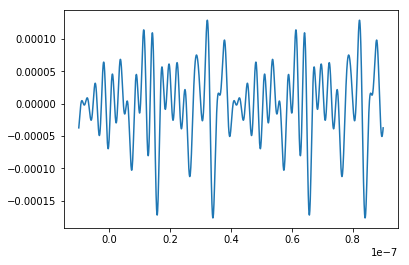

In [15]:
short_noise = pyrex.ThermalNoise(times=time_array, temperature=noise_temp,
                                 resistance=system_resistance,
                                 f_band=(100e6, 400e6))
long_noise = short_noise.with_times(np.linspace(-10e-9, 90e-9, 2001))

plt.plot(short_noise.times, short_noise.values)
plt.show()
plt.plot(long_noise.times, long_noise.values)
plt.show()

<a id="antennas"></a>
# Antenna Class and Subclasses

The base ``Antenna`` class provided by PyREx is designed to be inherited from to match the needs of each project. At its core, an ``Antenna`` object is initialized with a position, a temperature, and a frequency range, as well as optionally a resistance for noise calculations and a boolean dictating whether or not noise should be added to the antenna's signals (note that if noise is to be added, a resistance must be specified).

In [16]:
# Please note that some values are unrealistic for demonstration purposes
position = (0, 0, -100) # m
temperature = 300 # K
resistance = 1e17 # ohm
frequency_range = (0, 5) # Hz
basic_antenna = pyrex.Antenna(position=position, temperature=temperature,
                              resistance=resistance,
                              freq_range=frequency_range)
noiseless_antenna = pyrex.Antenna(position=position, noisy=False)

The basic properties of an ``Antenna`` object are ``is_hit`` and ``waveforms``. ``is_hit`` specifies whether or not the antenna has been triggered by an event. ``waveforms`` is a list of all the waveforms which have triggered the antenna. The antenna also defines ``signals``, which is a list of all signals the antenna has received, and ``all_waveforms`` which is a list of all waveforms (signal plus noise) the antenna has received including those which didn't trigger.

In [17]:
print(basic_antenna.is_hit == False)
print(basic_antenna.waveforms == [])

True
True


The ``Antenna`` class contains two attributes and three methods which represent characteristics of the antenna as they relate to signal processing. The attributes are ``efficiency`` and ``antenna_factor``, and the methods are ``response``, ``directional_gain``, and ``polarization_gain``. The attributes are to be set and the methods overwritten in order to custmoize the way the antenna responds to incoming signals. ``efficiency`` is simply a scalar which multiplies the signal the antenna receives (default value is ``1``). ``antenna_factor`` is a factor used in converting received electric fields into voltages (``antenna_factor`` = E / V; default value is ``1``). ``response`` takes a frequency or list of frequencies (in Hz) and returns the frequency response of the antenna at each frequency given (default always returns ``1``). ``directional_gain`` takes angles theta and phi in the antenna's coordinates and returns the antenna's gain for a signal coming from that direction (default always returns ``1``). ``directional_gain`` is dependent on the antenna's orientation, which is defined by its ``z_axis`` and ``x_axis`` attributes. To change the antenna's orientation, use the ``set_orientation`` method which takes ``z_axis`` and ``x_axis`` arguments. Finally, ``polarization_gain`` takes a polarization vector and returns the antenna's gain for a signal with that polarization (default always returns ``1``).

In [18]:
print(basic_antenna.efficiency == 1)
print(basic_antenna.antenna_factor == 1)
freqs = [1, 2, 3, 4, 5]
print(basic_antenna.response(freqs) == [1, 1, 1, 1, 1])
print(basic_antenna.directional_gain(theta=np.pi/2, phi=0) == 1)
print(basic_antenna.polarization_gain([0,0,1]) == 1)

True
True
[ True  True  True  True  True]
True
True


The ``Antenna`` class defines a ``trigger`` method which is also expected to be overwritten. ``trigger`` takes a ``Signal`` object as an argument and returns a boolean of whether or not the antenna would trigger on that signal (default always returns ``True``).

In [19]:
print(basic_antenna.trigger(pyrex.Signal([0],[0])) == True)

True


The ``Antenna`` class also defines a ``receive`` method which takes a ``Signal`` object and processes the signal according to the antenna's attributes (``efficiency``, ``antenna_factor``, ``response``, ``directional_gain``, and ``polarization_gain`` as described above). To use the ``receive`` function, simply pass it the ``Signal`` object the antenna sees, and the ``Antenna`` class will handle the rest. You can also optionally specify the direction of travel of the signal (used in ``directional_gain`` calculation) and the polarization direction of the signal (used in ``polarization_gain`` calculation). If either of these is unspecified, the corresponding gain will simply be set to ``1``.

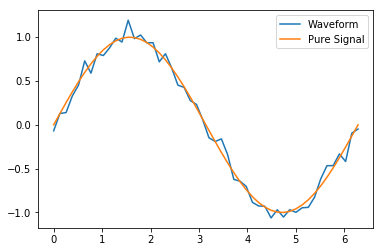

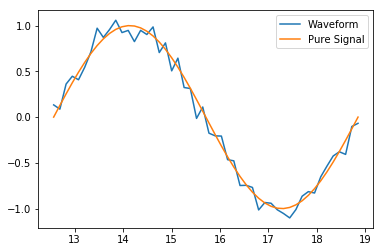

In [20]:
incoming_signal_1 = pyrex.FunctionSignal(np.linspace(0,2*np.pi), np.sin,
                                         value_type=pyrex.Signal.Type.voltage)
incoming_signal_2 = pyrex.FunctionSignal(np.linspace(4*np.pi,6*np.pi), np.sin,
                                         value_type=pyrex.Signal.Type.voltage)
basic_antenna.receive(incoming_signal_1)
basic_antenna.receive(incoming_signal_2, direction=[0,0,1], polarization=[1,0,0])
basic_antenna.is_hit == True
for waveform, pure_signal in zip(basic_antenna.waveforms, basic_antenna.signals):
    plt.figure()
    plt.plot(waveform.times, waveform.values, label="Waveform")
    plt.plot(pure_signal.times, pure_signal.values, label="Pure Signal")
    plt.legend()
    plt.show()

Beyond ``Antenna.waveforms``, the ``Antenna`` object also provides methods for checking the waveform and trigger status for arbitrary times: ``full_waveform`` and ``is_hit_during``. Both of these methods take a time array as an argument and return the waveform ``Signal`` object for those times and whether said waveform triggered the antenna, respectively.

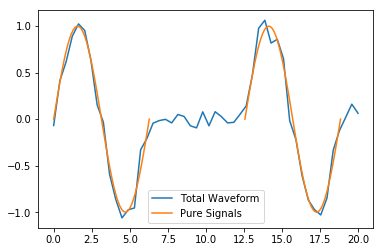

True


In [21]:
total_waveform = basic_antenna.full_waveform(np.linspace(0,20))
plt.plot(total_waveform.times, total_waveform.values, label="Total Waveform")
plt.plot(incoming_signal_1.times, incoming_signal_1.values, label="Pure Signals")
plt.plot(incoming_signal_2.times, incoming_signal_2.values, color="C1")
plt.legend()
plt.show()

print(basic_antenna.is_hit_during(np.linspace(0, 200e-9)) == True)

Finally, the ``Antenna`` class defines a ``clear`` method which will reset the antenna to a state of having received no signals:

In [22]:
basic_antenna.clear()
print(basic_antenna.is_hit == False)
print(len(basic_antenna.waveforms) == 0)

True
True


The ``clear`` method can also optionally reset the source of noise waveforms by passing ``reset_noise=True`` so that if the same signals are given after the antenna is cleared, the noise waveforms will be different:

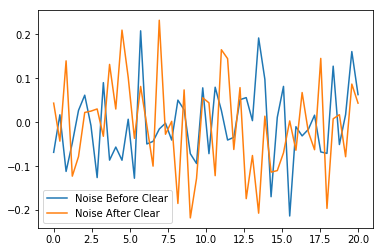

In [23]:
noise_before = basic_antenna.make_noise(np.linspace(0, 20))
plt.plot(noise_before.times, noise_before.values, label="Noise Before Clear")
basic_antenna.clear(reset_noise=True)
noise_after = basic_antenna.make_noise(np.linspace(0, 20))
plt.plot(noise_after.times, noise_after.values, label="Noise After Clear")
plt.legend()
plt.show()

To create a custom antenna, simply inherit from the ``Antenna`` class:

In [24]:
class NoiselessThresholdAntenna(pyrex.Antenna):
    def __init__(self, position, threshold):
        super().__init__(position=position, noisy=False)
        self.threshold = threshold

    def trigger(self, signal):
        if max(np.abs(signal.values)) > self.threshold:
            return True
        else:
            return False

Our custom ``NoiselessThresholdAntenna`` should only trigger when the amplitude of a signal exceeds its threshold value:

True
True
True
True
True
True


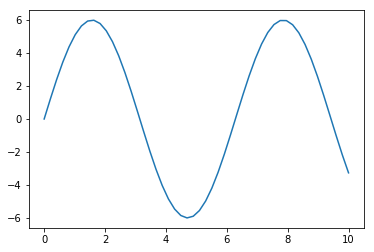

In [25]:
my_antenna = NoiselessThresholdAntenna(position=(0, 0, 0), threshold=2)

incoming_signal = pyrex.FunctionSignal(np.linspace(0,10), np.sin,
                                       value_type=pyrex.Signal.Type.voltage)
my_antenna.receive(incoming_signal)
print(my_antenna.is_hit == False)
print(len(my_antenna.waveforms) == 0)
print(len(my_antenna.all_waveforms) == 1)

incoming_signal = pyrex.Signal(incoming_signal.times,
                               5*incoming_signal.values,
                               value_type=incoming_signal.value_type)
my_antenna.receive(incoming_signal)
print(my_antenna.is_hit == True)
print(len(my_antenna.waveforms) == 1)
print(len(my_antenna.all_waveforms) == 2)

for wave in my_antenna.waveforms:
    plt.figure()
    plt.plot(wave.times, wave.values)
    plt.show()

PyREx defines ``DipoleAntenna``, a subclass of ``Antenna`` which provides a basic threshold trigger, a basic bandpass filter frequency response, a sine-function directional gain, and a typical dot-product polarization effect. A ``DipoleAntenna`` object is created as follows:

In [26]:
antenna_identifier = "antenna 1"
position = (0, 0, -100)
center_frequency = 250e6 # Hz
bandwidth = 300e6 # Hz
resistance = 100 # ohm
antenna_length = 3e8/center_frequency/2 # m
polarization_direction = (0, 0, 1)
trigger_threshold = 1e-5 # V
dipole = pyrex.DipoleAntenna(name=antenna_identifier,position=position,
                             center_frequency=center_frequency,
                             bandwidth=bandwidth, resistance=resistance,
                             effective_height=antenna_length,
                             orientation=polarization_direction,
                             trigger_threshold=trigger_threshold)

<a id="detector"></a>
# AntennaSystem and Detector Classes

The ``AntennaSystem`` class is designed to bridge the gap between the basic antenna classes and realistic antenna systems including front-end processing of the antenna's signals. It is designed to be subclassed, but by default it takes as an argument the ``Antenna`` class or subclass it is extending, or an object of that class. It provides an interface nearly identical to that of the ``Antenna`` class, but where a ``front_end`` method (which by default does nothing) is applied to the extended antenna's signals.

To extend an ``Antenna`` class or subclass into a full antenna system, subclass the ``AntennaSystem`` class and define the ``front_end`` method. Optionally a trigger can be defined for the antenna system (by default it uses the antenna's trigger):

In [27]:
class PowerAntennaSystem(pyrex.AntennaSystem):
    """Antenna system whose signals and waveforms are powers instead of
    voltages."""
    def __init__(self, position, temperature, resistance, frequency_range):
        super().__init__(pyrex.Antenna)
        # The setup_antenna method simply passes all arguments on to the
        # antenna class passed to super.__init__() and stores the resulting
        # antenna to self.antenna
        self.setup_antenna(position=position, temperature=temperature,
                           resistance=resistance,
                           freq_range=frequency_range)

    def front_end(self, signal):
        return pyrex.Signal(signal.times, signal.values**2,
                            value_type=pyrex.Signal.Type.power)

Objects of this class can then, for the most part, be interacted with as though they were regular antenna objects:

True
True


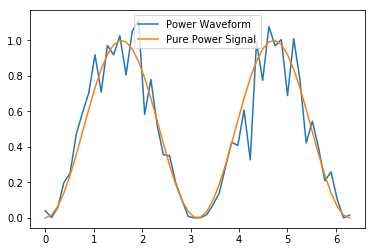

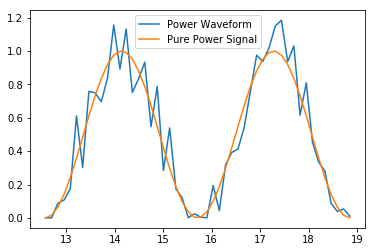

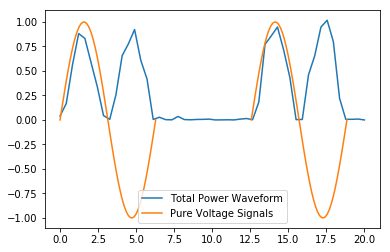

True
True
True


In [28]:
position = (0, 0, -100) # m
temperature = 300 # K
resistance = 1e17 # ohm
frequency_range = (0, 5) # Hz

basic_antenna_system = PowerAntennaSystem(position=position,
                                          temperature=temperature,
                                          resistance=resistance,
                                          frequency_range=frequency_range)

print(basic_antenna_system.trigger(pyrex.Signal([0],[0])) == True)

incoming_signal_1 = pyrex.FunctionSignal(np.linspace(0,2*np.pi), np.sin,
                                         value_type=pyrex.Signal.Type.voltage)
incoming_signal_2 = pyrex.FunctionSignal(np.linspace(4*np.pi,6*np.pi), np.sin,
                                         value_type=pyrex.Signal.Type.voltage)
basic_antenna_system.receive(incoming_signal_1)
basic_antenna_system.receive(incoming_signal_2, direction=[0,0,1],
                             polarization=[1,0,0])
print(basic_antenna_system.is_hit == True)
for waveform, pure_signal in zip(basic_antenna_system.waveforms,
                                 basic_antenna_system.signals):
    plt.figure()
    plt.plot(waveform.times, waveform.values, label="Power Waveform")
    plt.plot(pure_signal.times, pure_signal.values, label="Pure Power Signal")
    plt.legend()
    plt.show()

total_waveform = basic_antenna_system.full_waveform(np.linspace(0,20))
plt.plot(total_waveform.times, total_waveform.values, label="Total Power Waveform")
plt.plot(incoming_signal_1.times, incoming_signal_1.values, label="Pure Voltage Signals")
plt.plot(incoming_signal_2.times, incoming_signal_2.values, color="C1")
plt.legend()
plt.show()

print(basic_antenna_system.is_hit_during(np.linspace(0, 200e-9)) == True)

basic_antenna_system.clear()
print(basic_antenna_system.is_hit == False)
print(len(basic_antenna_system.waveforms) == 0)

The ``Detector`` class is another convenience class meant to be subclassed. It is useful for automatically generating many antennas (as would be used to build a detector). Subclasses must define a ``set_positions`` method to assign vector positions to the self.antenna_positions attribute. By default ``set_positions`` will raise a ``NotImplementedError``. Additionally subclasses may extend the default ``build_antennas`` method which by default simply builds antennas of a passed antenna class using any keyword arguments passed to the method. In addition to simply generating many antennas at desired positions, another convenience of the ``Detector`` class is that once the ``build_antennas`` method is run, it can be iterated directly as though the object were a list of the antennas it generated. An example of subclassing the ``Detector`` class is shown below:

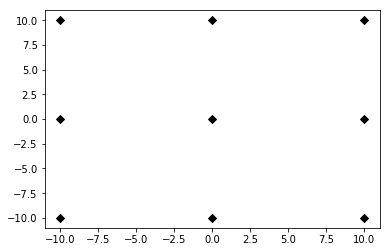

In [29]:
class AntennaGrid(pyrex.Detector):
    """A detector composed of a plane of antennas in a rectangular grid layout
    some distance below the ice."""
    def set_positions(self, number, separation=10, depth=-50):
        self.antenna_positions = []
        n_x = int(np.sqrt(number))
        n_y = int(number/n_x)
        dx = separation
        dy = separation
        for i in range(n_x):
            x = -dx*n_x/2 + dx/2 + dx*i
            for j in range(n_y):
                y = -dy*n_y/2 + dy/2 + dy*j
                self.antenna_positions.append((x, y, depth))

grid_detector = AntennaGrid(9)

# Build the antennas
temperature = 300 # K
resistance = 1e17 # ohm
frequency_range = (0, 5) # Hz
grid_detector.build_antennas(pyrex.Antenna, temperature=temperature,
                             resistance=resistance,
                             freq_range=frequency_range)

for antenna in grid_detector:
    x = antenna.position[0]
    y = antenna.position[1]
    plt.plot(x, y, "kD")
plt.show()

Due to the parallels between ``Antenna`` and ``AntennaSystem``, an antenna system may also be used in the custom detector class. Note however, that the antenna positions must be accessed as ``antenna.antenna.position`` since we didn't define a position attribute for the ``PowerAntennaSystem``:

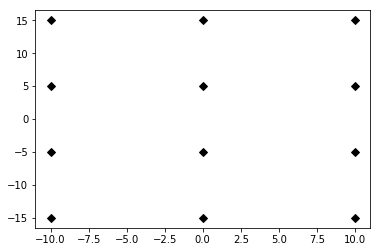

In [30]:
grid_detector = AntennaGrid(12)

# Build the antennas
temperature = 300 # K
resistance = 1e17 # ohm
frequency_range = (0, 5) # Hz
grid_detector.build_antennas(PowerAntennaSystem, temperature=temperature,
                             resistance=resistance,
                             frequency_range=frequency_range)

for antenna in grid_detector:
    x = antenna.antenna.position[0]
    y = antenna.antenna.position[1]
    plt.plot(x, y, "kD")
plt.show()

<a id="models"></a>
# Ice and Earth Models

PyREx provides a class ``IceModel``, which is an alias for whichever south pole ice model class is the preferred (currently just the basic ``AntarcticIce``). The ``IceModel`` class provides class methods for calculating characteristics of the ice at different depths and frequencies outlined below:

In [31]:
depth = -1000 # m
print(pyrex.IceModel.temperature(depth))
print(pyrex.IceModel.index(depth))
print(pyrex.IceModel.gradient(depth))
frequency = 1e8 # Hz
print(pyrex.IceModel.attenuation_length(depth, frequency))

226.57523999999998
1.7799992042414852
[ 0.00000000e+00  0.00000000e+00 -1.05040124e-08]
1901.6173455521994


PyREx also provides two functions realted to its earth model: ``prem_density`` and ``slant_depth``. ``prem_density`` calculates the density in grams per cubic centimeter of the earth at a given radius:

In [32]:
radius = 6360000 # m
pyrex.prem_density(radius)

array(2.6)

``slant_depth`` calculates the material thickness in grams per square centimeter of a chord cutting through the earth at a given nadir angle, starting from a given depth:

In [33]:
nadir_angle = 60 * np.pi/180 # radians
depth = 1000 # m
pyrex.slant_depth(nadir_angle, depth)

2551121800.093456

<a id="ray_tracing"></a>
# Ray Tracing

PyREx provides ray tracing in the ``RayTracer`` and ``RayTracerPath`` classes. ``RayTracer`` takes a launch point and receiving point as arguments (and optionally an ice model and z-step), and will solve for the paths between the points (as ``RayTracerPath`` objects).

In [34]:
start = (0, 0, -250) # m
finish = (750, 0, -100) # m
my_ray_tracer = pyrex.RayTracer(from_point=start, to_point=finish)

The two most useful properties of ``RayTracer`` are ``RayTracer.exists`` and ``RayTracer.solutions``. ``RayTracer.exists`` is a boolean value of whether or not path solutions exist between the launch and receiving points. ``RayTracer.solutions`` is the list of (zero or two) ``RayTracerPath`` objects which exist between the launch and receiving points. There are many other properties available in ``RayTracer``, outlined in the API documentation, which are mostly used internally and maybe not interesting otherwise.

In [35]:
print(my_ray_tracer.exists)
print(my_ray_tracer.solutions)

True
[<pyrex.ray_tracing.SpecializedRayTracePath object at 0x1c0ff29080>, <pyrex.ray_tracing.SpecializedRayTracePath object at 0x1c0ff29048>]


The ``RayTracerPath`` class contains the attributes of the paths between points. The most useful properties of ``RayTracerPath`` are ``RayTracerPath.tof``, ``RayTracerPath.path_length``, ``RayTracerPath.emitted_direction``, and ``RayTracerPath.received_direction``. These properties provide the time of flight, path length, and direction of rays at the launch and receiving points respectively.

In [36]:
my_path = my_ray_tracer.solutions[0]
print(my_path.tof)
print(my_path.path_length)
print(my_path.emitted_direction)
print(my_path.received_direction)

4.389097686353611e-06
771.3560000248904
[0.94039118 0.         0.34009474]
[ 0.99630666  0.         -0.08586643]


``RayTracePath`` also provides the ``RayTracePath.attenuation()`` method which gives the attenuation of the signal at a given frequency (or frequencies), and the ``RayTracePath.coordinates`` property which gives the x, y, and z coordinates of the path (useful mostly for plotting, and are not garuanteed to be accurate for other purposes).

[0.76730746]
[0.76730746 0.68491608 0.63793496 0.60408896 0.57738512 0.55523965]


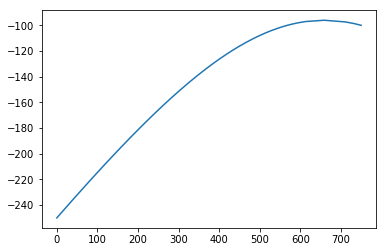

In [37]:
frequency = 500e6 # Hz
print(my_path.attenuation(100e6))
print(my_path.attenuation(np.linspace(1e8, 1e9, 6)))
plt.plot(my_path.coordinates[0], my_path.coordinates[2])
plt.show()

Finally, ``RayTracePath.propagate`` propagates a ``Signal`` object from the launch point to the receiving point of the path by applying the frequency-dependent attenuation from ``RayTracePath.attenuation``, and shifting the signal times by ``RayTracePath.tof``. Note that it does not apply a 1/R effect based on the path length. If needed, this effect should be added in manually. ``RayTracePath.propagate`` can also propagate the polarization vector of the signal, either independently or in the same function call.

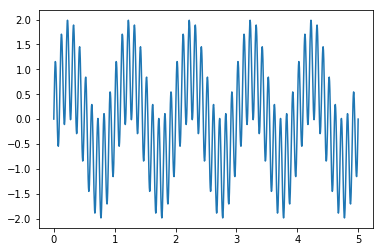

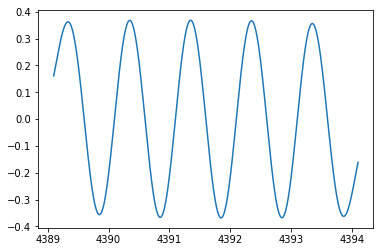

[0.04419396 0.85738077 0.51278173]


In [38]:
time_array = np.linspace(0, 5e-9, 1001)
launch_signal = (
    pyrex.FunctionSignal(time_array, lambda t: np.sin(1e9*2*np.pi*t))
    + pyrex.FunctionSignal(time_array, lambda t: np.sin(1e10*2*np.pi*t))
)
plt.plot(launch_signal.times*1e9, launch_signal.values)
plt.show()
launch_pol = 1/np.sqrt(np.array([3, 3, 3]))

rec_signal, rec_pol = my_path.propagate(launch_signal, polarization=launch_pol)
plt.plot(rec_signal.times*1e9, rec_signal.values)
plt.show()
print(rec_pol)

<a id="particles"></a>
# Particle Generation

PyREx includes ``Particle`` as a container for information about neutrinos which are generated to produce Askaryan pulses. ``Particle`` contains three attributes: ``vertex``, ``direction``, and ``energy``:

In [39]:
particle_type = pyrex.Particle.Type.electron_neutrino
initial_position = (0,0,0) # m
direction_vector = (0,0,-1)
particle_energy = 1e8 # GeV
particle = pyrex.Particle(particle_id=particle_type, vertex=initial_position,
                          direction=direction_vector, energy=particle_energy)
print(particle)

The ``interaction`` attribute is an instance of an ``Interaction`` class (``NeutrinoInteraction`` by default) which is a model for how the neutrino interacts in the ice. It has a ``kind`` denoting whether the interaction will be charged-current or neutral-current, an ``inelasticity``, ``em_frac`` and ``had_frac`` describing the resulting particle shower(s), and ``cross_section`` and ``interaction_length`` in the ice at the energy of the parent ``Particle`` object:

In [40]:
print(type(particle.interaction))
print(particle.interaction.kind)
print(particle.interaction.inelasticity)
print(particle.interaction.em_frac)
print(particle.interaction.had_frac)
print(particle.interaction.cross_section)
print(particle.interaction.interaction_length)

<class 'pyrex.particle.CTWInteraction'>
Type.charged_current
0.1573561619277291
0.842643838072271
0.1573561619277291
4.8517943603703196e-33
342374273.2533133


PyREx also includes a ``ShadowGenerator`` class for generating random neutrinos, taking into account some Earth shadowing. The neutrinos are generated in a box of given size, and with a given energy (which can be a scalar value or a function returning scalar values):

In [41]:
box_width = 1000 # m
box_depth = 500 # m
flavor_ratio = (1, 1, 1) # even distribution of neutrino flavors
my_generator = pyrex.ShadowGenerator(dx=box_width, dy=box_width,
                                     dz=box_depth,
                                     energy=particle_energy,
                                     flavor_ratio=flavor_ratio)
print(my_generator.create_event())

The ``ShadowGenerator.create_event`` method returns an ``Event`` object, which contains a tree of ``Particle`` objects representing the event. Currently this tree will only contain a single neutrino, but could be expanded in the future in order to describe more exotic events. The neutrino is available as the only element in the list ``Event.roots``. It could also be accessed by iterating the ``Event`` object.

Lastly, PyREx includes ``ListGenerator`` and ``FileGenerator`` classes which can be used to reproduce pre-generated events from either a list or from numpy files, respectively. For example, to continuously re-throw our ``Particle`` object from above:

In [42]:
repetitive_generator = pyrex.ListGenerator([pyrex.Event(particle)])
print(repetitive_generator.create_event())
print(repetitive_generator.create_event())

<a id="kernel"></a>
# Full Simulation

PyREx provides the ``EventKernel`` class to control a basic simulation including the creation of neutrinos, the propagation of their pulses to the antennas, and the triggering of the antennas. The ``EventKernel`` is designed to be modular and can use a specific ice model, ray tracer, and signal times as specified in optional arguments (the defaults are explicitly specified below):

Particle type:    Type.electron_neutrino
Shower vertex:    [ 237.4665768   -52.54398778 -254.71269121]
Shower axis:      [-0.84160641 -0.22081956 -0.49288678]
Particle energy:  100000000.0
Interaction type: Type.charged_current
Electromagnetic shower fraction: 0.9991370445067689
Hadronic shower fraction:        0.0008629554932311303
Event weight: 0.0003036605022636449


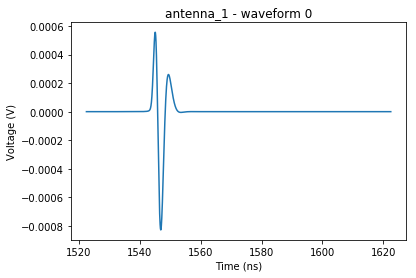

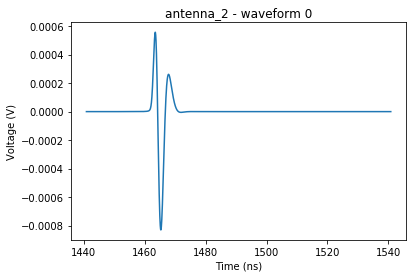

In [43]:
particle_generator = pyrex.ShadowGenerator(dx=1000, dy=1000, dz=500,
                                           energy=1e8)
detector = []
for i, z in enumerate([-100, -150, -200, -250]):
    detector.append(
        pyrex.DipoleAntenna(name="antenna_"+str(i), position=(0, 0, z),
                            center_frequency=250e6, bandwidth=300e6,
                            resistance=0, effective_height=0.6,
                            trigger_threshold=1e-4, noisy=False)
    )
kernel = pyrex.EventKernel(generator=particle_generator,
                           antennas=detector,
                           ice_model=pyrex.IceModel,
                           ray_tracer=pyrex.RayTracer,
                           signal_times=np.linspace(-20e-9, 80e-9, 2000,
                                                    endpoint=False))

triggered = False
while not triggered:
    event = kernel.event()
    for antenna in detector:
        if antenna.is_hit:
            triggered = True
            break
            
particle = event.roots[0]
print("Particle type:   ", particle.id)
print("Shower vertex:   ", particle.vertex)
print("Shower axis:     ", particle.direction)
print("Particle energy: ", particle.energy)
print("Interaction type:", particle.interaction.kind)
print("Electromagnetic shower fraction:", particle.interaction.em_frac)
print("Hadronic shower fraction:       ", particle.interaction.had_frac)
print("Event weight:", particle.weight)

for antenna in detector:
    for i, wave in enumerate(antenna.waveforms):
        plt.plot(wave.times * 1e9, wave.values)
        plt.xlabel("Time (ns)")
        plt.ylabel("Voltage (V)")
        plt.title(antenna.name + " - waveform "+str(i))
        plt.show()

<a id="data_io"></a>
# Data File I/O

The ``File`` class controls the reading and writing of data files for simulation. At the most basic it takes a filename and mode in which to open the file, and if the file type is supported the object will be the appropriate file handler. Like python's ``open`` function, the ``File`` class works as a context manager and should preferrably be used in ``with`` statements. Currently the only data file type supported by PyREx is HDF5. Depending on whether an HDF5 file is being read or written there are additional keyword arguments that may be provided to ``File``. HDF5 files support the following modes: 'r' for read-only, 'w' for write (overwrites existing file), 'a'/'r+' for append (doesn't overwrite existing file), and 'x' for write (fails if file exists already).

If writing an HDF5 file, the optional arguments specify which event data to write. The available write options are ``write_particles``, ``write_triggers``, ``write_antenna_triggers``, ``write_rays``, ``write_noise``, and ``write_waveforms``. Most of these are self-explanatory, but ``write_antenna_triggers`` will write triggering information for each antenna in the detector and ``write_noise`` will write the frequency data required to replicate noise waveforms. The last optional argument is ``require_trigger`` which specifies which data should only be written when the detector is triggered. If a boolean value, requires trigger or not for all data with the exception of particle and trigger data, which is always written. If a list of strings, the listed data will require triggers and any other data will always be written.

The most straightforward way to write data files is to pass a ``File`` object to the ``EventKernel`` object handling the simulation. In such a case, a global trigger condition should be passed to the ``EventKernel`` as well, either as a function which acts on a detector object, or as the "global" key in a dictionary of functions representing various trigger conditions:

In [44]:
particle_generator = pyrex.ShadowGenerator(dx=1000, dy=1000, dz=500,
                                           energy=1e8)
detector = []
for i, z in enumerate([-100, -150, -200, -250]):
    detector.append(
        pyrex.DipoleAntenna(name="antenna_"+str(i), position=(0, 0, z),
                            center_frequency=250e6, bandwidth=300e6,
                            resistance=0, effective_height=0.6,
                            trigger_threshold=1e-4, noisy=False)
    )

def global_trigger_condition(det):
    for ant in det:
        if ant.is_hit:
            return True
    return False

def even_antenna_trigger(det):
    for i, ant in enumerate(det):
        if i%2==0 and ant.is_hit:
            return True
    return False

trigger_conditions = {
    "global": global_trigger_condition,
    "evens": even_antenna_trigger,
    "ant1": lambda det: det[1].is_hit
}

with pyrex.File('my_data_file.h5', 'x') as f:
    kernel = pyrex.EventKernel(generator=particle_generator,
                               antennas=detector,
                               event_writer=f,
                               triggers=trigger_conditions)

    for _ in range(10):
        event, triggered = kernel.event()

If you want to manually write the data file, then the ``File.set_detector`` and ``File.add`` methods are necessary. ``File.set_detector`` associates the given antennas with the file object (and writes their data) and ``File.add`` adds the data from the given event to the file. Here we also manually open and close the file object with ``File.open`` and ``File.close``, and add some metadata to the file with ``File.add_file_metadata``:

In [45]:
f = pyrex.File('my_data_file_2.h5', 'w', write_rays=False)
f.open()

f.add_file_metadata({"write_style": "manual", "number_of_events": 10})

f.set_detector(detector)

kernel = pyrex.EventKernel(generator=particle_generator,
                           antennas=detector)

for _ in range(10):
    event = kernel.event()
    triggered = False
    for antenna in detector:
        if antenna.is_hit:
            triggered = True
            break
    f.add(event, triggered=triggered)

f.close()

The ``File`` objects also support writing miscellaneous analysis data to the file. ``File.create_analysis_dataset`` creates and returns a basic HDF5 dataset. ``File.create_analysis_metadataset`` creates a joined set of tables for string and float data, which can be written to with ``File.add_analysis_metadata``. And finally, ``File.add_analysis_indices`` allows for linking event indices to specific rows of analysis data.

In [46]:
with pyrex.File('my_data_file.h5', 'a') as f:
    f.create_analysis_metadataset("effective_volume")
    gen_vol = 1000*1000*500
    data = {
        "generation_volume": gen_vol,
        "veff": 5/10*gen_vol,
        "error": np.sqrt(5)/10*gen_vol,
        "unit": "m^3"
    }
    f.add_analysis_metadata("effective_volume", data)

    other = f.create_analysis_dataset("meaningless_data",
                                      data=np.ones((20, 5)))
    other.attrs['rows_per_event'] = 2
    for i in range(10):
        f.add_analysis_indices("meaningless_data", global_index=i,
                               start_index=2*i, length=2)

If reading an HDF5 file, the ``slice_range`` argument specifies the size of event slices to load into memory at once when iterating over events. In general, increasing the ``slice_range`` will improve the speed of iteration at the cost of greater memory consumption.

In [47]:
with pyrex.File('my_data_file.h5', 'r', slice_range=100) as f:
    pass

When reading HDF5 files, there are a number of methods and attributes available to access the data. With the ``File`` object alone, ``File.file_metadata`` contains a dictionary of the file's metadata and ``File.antenna_info`` contains a list of dictionaries with data for each antenna in the detector the file was run with. If waveform data is available, ``File.get_waveforms`` can be used to get all waveforms in the file or a specific subset based on ``event_id``, ``antenna_id``, and ``waveform_type`` arguments. Finally, direct access to the contents of the HDF5 file is supported through either the proper paths or nicknames.

In [48]:
with pyrex.File('my_data_file.h5', 'r') as f:
    print(f.file_metadata)
    print(f.antenna_info[0])
    
    # No waveform data was stored above, so these will fail if run
    # All waveforms:
    # wfs = f.get_waveforms()
    # Waveforms from event 0
    # wfs = f.get_waveforms(event_id=0)
    # Waveforms in antenna 1 from all events
    # wfs = f.get_waveforms(antenna_id=1)
    # Direct waveform in antenna 4 from event 5
    # wf = f.get_waveforms(event_id=5, antenna_id=4, waveform_type=0)
    # Using full file path
    
    triggers = f['data/triggers']
    # Using dataset nickname
    particle_string_metadata = f['particles_meta_str']
    # Using analysis dataset nickname
    other = f['meaningless_data']

{'file_version': '1.0', 'pyrex_version': '1.8.1', 'opening_script': '<ipython-input-44-03257e6cf3aa>', 'top_level_script': '/anaconda3/lib/python3.6/runpy.py', 'datetime': '2018-16-11 15:03:53', 'date': '2018-16-11', 'time': '15:03:53', 'file_version_major': 1.0, 'file_version_minor': 0.0, 'pyrex_version_major': 1.0, 'pyrex_version_minor': 8.0, 'pyrex_version_patch': 1.0, 'year': 2018.0, 'month': 11.0, 'day': 16.0, 'hour': 15.0, 'minute': 3.0, 'second': 53.0}
{'position_x': 0.0, 'position_y': 0.0, 'position_z': -100.0, 'z_axis_x': 0.0, 'z_axis_y': 0.0, 'z_axis_z': 1.0, 'x_axis_x': -0.06817574362941099, 'x_axis_y': 0.9976733272873325, 'x_axis_z': 0.0, 'class': "<class 'pyrex.antenna.DipoleAntenna'>", 'name': 'antenna_0', 'antenna_factor': 1.6666666666666667, 'efficiency': 1.0, 'noisy': 0.0, 'unique_noises': 10.0, 'freq_range_min': 100000000.0, 'freq_range_max': 400000000.0, 'noise_rms': nan, 'temperature': 222.34937505, 'resistance': 0.0, 'threshold': 0.0001, 'effective_height': 0.6}


HDF5 files opened in read-only mode can also be iterated over, which allows access to the data for each event in turn. When iterating, the event objects have the following methods for accessing data. ``get_particle_info`` and ``get_rays_info`` return a list of dictionaries or attribute values for the event's particles or rays, respectively. The ``is_neutrino``, ``is_nubar``, and ``flavor`` attributes also contain the associated basic information about the base particle of the event. ``get_waveforms`` returns the waveforms for the event, or a specific subset based on ``antenna_id`` and ``waveform_type`` (as above). The ``triggered`` attribute contains whether the event triggered the detector and the ``get_triggered_components`` method returns a list of the trigger conditions of the detector which were met (as specified when writing the file). And finally, if noise data is recorded for the event it is contained in the ``noise_bases`` attribute. Iteration of the HDF5 files supports slicing as long as the step size is positive-valued, and individual events can also be reached by indexing the ``File`` object.

In [49]:
with pyrex.File('my_data_file.h5', 'r') as f:
    for event in f:
        print(event.is_neutrino, event.is_nubar, event.flavor)
        print(event.triggered, event.get_triggered_components())

    for event in f[2:6:2]:
        print(event.get_particle_info('particle_name'),
              event.get_particle_info('vertex'))
        print(np.degrees(event.get_rays_info('receiving_angle')))

    print(f[5].get_rays_info('tof'))

    # No waveform data was stored above, so this will fail if run
    # wfs = f[5].get_waveforms(antenna_id=4)

True True muon
False []
True False tau
False []
True False electron
True ['evens', 'ant1']
True True electron
True ['evens', 'ant1']
True False electron
True ['evens', 'ant1']
True True tau
True ['evens', 'ant1']
True False muon
True ['evens', 'ant1']
True True electron
True ['evens', 'ant1']
True False electron
True ['evens', 'ant1']
True False electron
True ['evens', 'ant1']
['electron_neutrino'] [[141.76981281 392.12040352 -66.57344857]]
[[64.95099141 68.1066041  65.67301242 61.86029868]
 [54.15933441 50.88609375 48.11458787 45.47871376]]
['electron_neutrino'] [[ 277.95782583 -351.81078381 -350.50973242]]
[[113.94635009 111.1427429  106.83026061 101.59616691]
 [ 43.61863934  39.4306964   36.510013    34.20979539]]
[[3.13676611e-06 2.99151832e-06 2.85777109e-06 2.74331239e-06]
 [3.75270765e-06 3.97727118e-06 4.21644051e-06 4.46495768e-06]]
